In [2]:
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean.cm as cmo
import scipy.stats as st
#import functions as fun

In [40]:
mpl.rcParams['xtick.labelsize']       = 9
mpl.rcParams['ytick.labelsize']       = 9
mpl.rcParams['lines.linewidth']       = 2.
mpl.rcParams['axes.labelsize']        = 9
#mpl.rcParams['axes.labelweight']      = 'bold'
mpl.rcParams['axes.titlesize']        = 9
mpl.rcParams['font.family']           = 'serif'
#mpl.rcParams['axes.titleweight']      = 'bold'
mpl.rcParams['figure.subplot.bottom'] = .05
mpl.rcParams['figure.subplot.top']    = .9
mpl.rcParams['figure.subplot.left']   = .05
mpl.rcParams['figure.subplot.right']  = .85
mpl.rcParams['figure.subplot.wspace'] = .02
mpl.rcParams['figure.subplot.hspace'] = .0
mpl.rcParams['figure.figsize']        = 7,5


cols = {}
cols['ocean'] = '.7'
cols['land'] = '.9'

In [6]:
#Get 1x1 degree grid
with xr.open_dataset('../rawdata/rsl_85_2090.nc') as ds:
    lon = ds['x'].values
    lat = ds['y'].values
    slr_md = ds['slr_md'].values

#Get fingerprints
with xr.open_dataset('../../srocc/data/result_thwaites.nc') as ds:
    lon05  = ds['x'].values
    lat05  = ds['y'].values
    fp05_a = 1000.*ds['RSL'].values
    
#Convert to 1x1 degree grid
fp_a  = np.zeros((len(lat),len(lon)))

for i,ii in enumerate(lat):
    ig = np.argmin((ii-lat05)**2)
    for j,jj in enumerate(lon):
        jg = np.argmin((jj-lon05)**2)
        fp_a[i,j] = fp05_a[ig,jg]

In [46]:
def get_sig(scen):
    sig = {}
      
    file = f'../../srocc/data/component-ts-slr-{scen[-2:]}.nc'
    with xr.open_dataset(file) as ds:
        var_h = np.nanmean(ds['ocn_h'][-20:,:,:].values,axis=0)
        var_l = np.nanmean(ds['ocn_l'][-20:,:,:].values,axis=0)
        sig['stdn'] = 100*.5*np.abs((var_h-var_l))/1.645

        var_h = np.nanmean(ds['glac_h'][-20:,:,:].values,axis=0)
        var_l = np.nanmean(ds['glac_l'][-20:,:,:].values,axis=0)
        sig['glac'] = 100*.5*np.abs((var_h-var_l))/1.645    

        var_h = np.nanmean(ds['greensmb_h'][-20:,:,:].values,axis=0)
        var_l = np.nanmean(ds['greensmb_l'][-20:,:,:].values,axis=0)
        sig['gsmb'] = 100*.5*np.abs((var_h-var_l))/1.645      

        if scen=='45':
            var_h = 12.6*fp_a
            var_l = 0.7*fp_a
        elif scen=='85':
            var_h = 22.9*fp_a
            var_l = 1.7*fp_a

        sig['adyn'] = .5*np.abs((var_h-var_l))/1.645

        var_h = np.nanmean(ds['greendyn_h'][-20:,:,:].values,axis=0)
        var_l = np.nanmean(ds['greendyn_l'][-20:,:,:].values,axis=0)
        sig['gdyn'] = 100*.5*np.abs((var_h-var_l))/1.645         
        
        var_h = np.nanmean(ds['grw_h'][-20:,:,:].values,axis=0)
        var_l = np.nanmean(ds['grw_l'][-20:,:,:].values,axis=0)
        sig['grw'] = 100*.5*np.abs((var_h-var_l))/1.645      

        sig['gia'] = 100*np.nanmean(ds['gia_sd'][-20:,:,:].values,axis=0)

    return sig

/Users/erwin/miniconda2/envs/codep/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  
/Users/erwin/miniconda2/envs/codep/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys
/Users/erwin/miniconda2/envs/codep/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.
/Users/erwin/miniconda2/envs/codep/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()
/Users/erwin/miniconda2/envs/codep/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  
/Users/erwin/miniconda2/envs/codep/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app
/Users/erwin/miniconda2/envs/codep/lib/python3.6/site-packages/ipykernel_launche

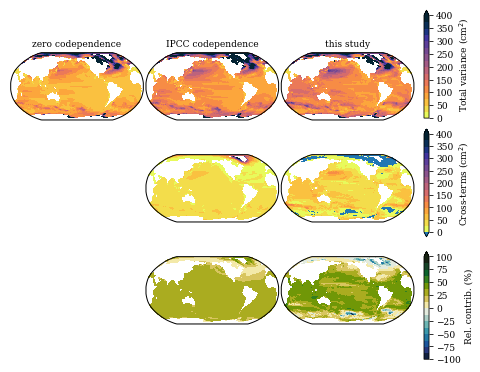

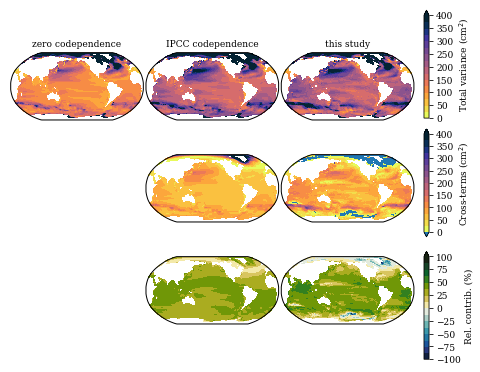

In [47]:
cmap1 = plt.get_cmap('cmo.thermal_r',16)
cmap1.set_under('tab:blue')
cmap2 = plt.get_cmap('cmo.delta',16)

for scen in ['rcp45','rcp85']:

    sig = get_sig(scen)
    with xr.open_dataset(f'../data/cov_{scen}.nc') as ds:
        cov = ds['cov'].values
        var1 = ds['var1'].values
        var2 = ds['var2'].values

    fig = plt.figure()

    indep = sig['stdn']**2+sig['glac']**2+sig['gsmb']**2+sig['adyn']**2+sig['gdyn']**2+sig['grw']**2+sig['gia']**2
    ct_sr = 2*sig['stdn']*sig['gsmb']
    srocc = indep+ct_sr

    ct_th = np.zeros((len(lat),len(lon)))
    for v in [0,1,3,4,6,8]:
        ct_th += 2*cov[v,:,:]*sig[var1[v]]*sig[var2[v]]

    thstud = indep+ct_th

    ax = fig.add_subplot(331,projection=ccrs.Robinson(central_longitude=200))
    im = ax.pcolormesh(lon,lat,indep,transform=ccrs.PlateCarree(),vmin=0,vmax=400,cmap=cmap1)
    ax.set_title('zero codependence')

    ax = fig.add_subplot(332,projection=ccrs.Robinson(central_longitude=200))
    im = ax.pcolormesh(lon,lat,srocc,transform=ccrs.PlateCarree(),vmin=0,vmax=400,cmap=cmap1)
    ax.set_title('IPCC codependence')

    ax = fig.add_subplot(333,projection=ccrs.Robinson(central_longitude=200))
    im = ax.pcolormesh(lon,lat,thstud,transform=ccrs.PlateCarree(),vmin=0,vmax=400,cmap=cmap1)
    ax.set_title('this study')

    cax = fig.add_axes([.87,.67,.01,.3])
    cb = plt.colorbar(im,cax=cax,extend='max')
    cb.set_label('Total variance (cm$^2$)')


    #ax = fig.add_subplot(334,projection=ccrs.Robinson(central_longitude=200))
    #im = ax.pcolormesh(lon,lat,0.*indep,transform=ccrs.PlateCarree(),vmin=0,vmax=400,cmap=cmap1)

    ax = fig.add_subplot(335,projection=ccrs.Robinson(central_longitude=200))
    im = ax.pcolormesh(lon,lat,ct_sr,transform=ccrs.PlateCarree(),vmin=0,vmax=400,cmap=cmap1)

    ax = fig.add_subplot(336,projection=ccrs.Robinson(central_longitude=200))
    im = ax.pcolormesh(lon,lat,ct_th,transform=ccrs.PlateCarree(),vmin=0,vmax=400,cmap=cmap1)

    cax = fig.add_axes([.87,.34,.01,.3])
    cb = plt.colorbar(im,cax=cax,extend='both')
    cb.set_label('Cross-terms (cm$^2$)')

    #ax = fig.add_subplot(337,projection=ccrs.Robinson(central_longitude=200))
    #im = ax.pcolormesh(lon,lat,0.*indep,transform=ccrs.PlateCarree(),vmin=-100,vmax=100,cmap=cmap2)

    ax = fig.add_subplot(338,projection=ccrs.Robinson(central_longitude=200))
    im = ax.pcolormesh(lon,lat,100*ct_sr/srocc,transform=ccrs.PlateCarree(),vmin=-100,vmax=100,cmap=cmap2)

    ax = fig.add_subplot(339,projection=ccrs.Robinson(central_longitude=200))
    im = ax.pcolormesh(lon,lat,100*ct_th/thstud,transform=ccrs.PlateCarree(),vmin=-100,vmax=100,cmap=cmap2)

    cax = fig.add_axes([.87,.0,.01,.3])
    cb = plt.colorbar(im,cax=cax,extend='max')
    cb.set_label('Rel. contrib. (%)')

    plt.savefig(f'../figures/plot_optionA_{scen}',dpi=600)
    plt.show()
    plt.close()